In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re
from collections import defaultdict
import seaborn as sns
from dataclasses import dataclass
import glob
from natsort import natsorted

np.random.seed(0)
def rand_jitter(arr):
    stdev = 0.00 
    return arr + np.random.randn(len(arr)) * stdev


cm = 1/2.54  # centimeters in inches\n",
    ##Change this to get a bigger figure. \n",
cmap = sns.color_palette("muted")
cmap = sns.color_palette("Set2")
cmap = sns.color_palette("hls", 4)


plt.rcParams.update({'font.size': 7})
plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.family':'arial'})

@dataclass
class result:
    mean_cov: float
    adj_ani: float
    naive_ani: float
    median_cov: float
    ref_file: str
    query_file: str
    low_ani: float
    high_ani: float
    lam: float
    true_eff_cov: float
        
        

[100, 250, 500, 1000] [31]
0.8231292517006803
0.8205128205128205
0.6833333333333333


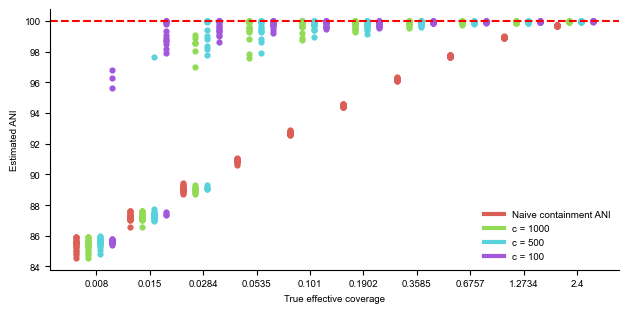

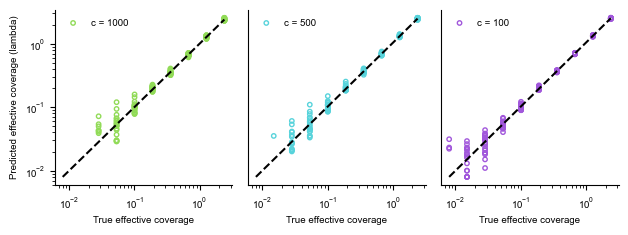

[100, 250, 500, 1000] [31]
0.890625
0.8695652173913043
0.6646341463414634


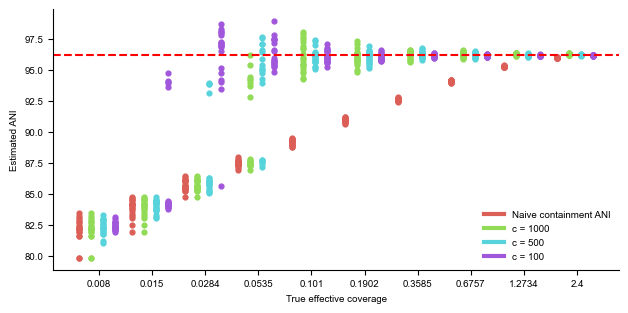

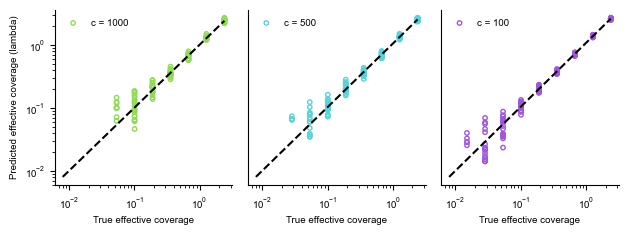

[100, 250, 500, 1000] [31]
0.7631578947368421
0.9292929292929293
0.8333333333333334


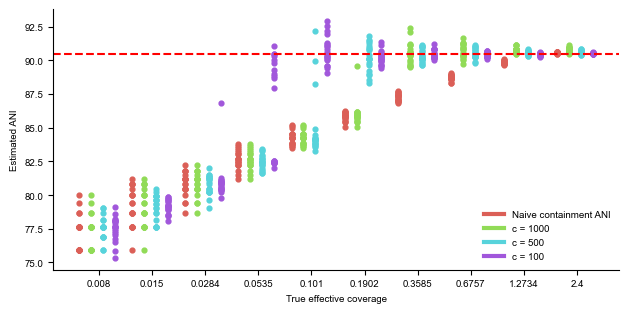

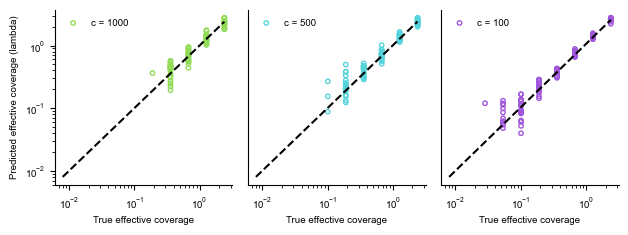

In [2]:
#21-500-10-0.48621887049186563.tsv
files_g = [glob.glob('synthetic_simulated_results/31-*-*'), glob.glob('synthetic_simulated_results_95/31-*-*'), glob.glob('synthetic_simulated_results_85/31-*-*')]

#files = sys.argv[2:]
true_anis = [100, 96.2, 90.5]
#true_ani = float(sys.argv[1])
#re_str = "(\d+)-(\d+\.?\d+)-.+\.fastq.gz"
re_str = "(\d+)-(\d+)-(\d+)-(\d+\.?\d+).tsv"
cutoff = 5 
lam_cutoff = 0.00

for l in range(3):
    cs = set()
    ks = set()
    ck_res = defaultdict(lambda: defaultdict(list))

    files = files_g[l]
    true_ani = true_anis[l]
    for file in files:
        x = re.findall(re_str, file)

        k = int(x[0][0])
        c = int(x[0][1])
        cs.add(c)
        ks.add(k)
        it = int(x[0][2])
        abund = round(float(x[0][3]),4)
        eff_cov = round((150 - k + 1) / 150 * abund,4)

        for line in open(file,'r'):
            if 'Naive' in line:
                continue
            spl = line.split()
            ref_file = spl[1]
            query_file = spl[0]
            naive_ani = float(spl[3])
            adj_ani = None
            if spl[5] == "NA" or "NA" in spl[4]:
                adj_ani = None
                lam = None
                cis = (None, None)
            else:
                ci = spl[4].split('-')
                adj_ani = float(spl[2])
                lam = float(spl[5])
            if "NA" in spl[4]:
                cis = (None, None)
            else:
                ci = spl[4].split('-')
                cis = float(ci[0]), float(ci[1])
            mean_cov = float(spl[9])
            median_cov = float(spl[8])
            res = result(mean_cov, adj_ani, naive_ani, median_cov, ref_file, query_file, cis[0], cis[1], lam, eff_cov)
            ck_res[c][k].append(res)

    cs = sorted(list(cs))
    ks = sorted(list(ks))
    print(cs,ks)

    mc_x = []
    diff_y = []
    naive_y = []
    max_diffs = []
    num_in = 0
    num_out = 0

    k = 31
    c = 1000

    results = ck_res[1000][k]
    x500 = []
    y500 = []

    x100 = []
    y100 = []

    x = []
    y = []
    z = []

    l500 = []
    l100 = []
    l = []

    cov_prob = []  
    cov_prob500 = []
    cov_prob100 = []
    for res in results:
        x.append(res.true_eff_cov)
        if res.adj_ani != None:
            y.append(res.adj_ani)
            l.append((res.true_eff_cov, res.lam))
            if true_ani <= res.high_ani and true_ani >= res.low_ani:
                cov_prob.append(1)
            else:
                cov_prob.append(0)
        else:
            y.append(res.naive_ani)
        z.append(res.naive_ani)


    for res in ck_res[500][k]:
        x500.append(res.true_eff_cov)
        if res.adj_ani != None:
            y500.append(res.adj_ani)
            l500.append((res.true_eff_cov, res.lam))
            if true_ani <= res.high_ani and true_ani >= res.low_ani:
                cov_prob500.append(1)
            else:
                cov_prob500.append(0)
        else:
            y500.append(res.naive_ani)

    for res in ck_res[100][k]:
        x100.append(res.true_eff_cov)
        if res.adj_ani != None:
            y100.append(res.adj_ani)
            l100.append((res.true_eff_cov, res.lam))
            if true_ani <= res.high_ani and true_ani >= res.low_ani:
                cov_prob100.append(1)
            else:
                cov_prob100.append(0)
        else:
            y100.append(res.naive_ani)


    print(np.mean(cov_prob))
    print(np.mean(cov_prob500))
    print(np.mean(cov_prob100))

    # Create a dictionary to group the data by x value
    grouped_data = {}

    for i in range(len(x)):
        if x[i] not in grouped_data:
            grouped_data[x[i]] = {'y': [], 'z': [], 'y500' : [], 'y100': []}
        grouped_data[x[i]]['y'].append(y[i])
        grouped_data[x[i]]['z'].append(z[i])
    for i in range(len(x500)):
        grouped_data[x500[i]]['y500'].append(y500[i])
    for i in range(len(x100)):
        grouped_data[x100[i]]['y100'].append(y100[i])


    # Create the boxplot
    box_colors = [cmap[i] for i in range(4)]
    fig, ax = plt.subplots(figsize = (16* cm , 8 * cm))
    boxes = []
    labels = []
    positions = []
    offset = 0.1
    width = 0.9
    s = 12

    for i, (key, value) in enumerate(sorted(grouped_data.items())):
        boxes.append(value['z'])
        boxes.append(value['y'])
        boxes.append(value['y500'])
        boxes.append(value['y100'])
        labels.append(str(key) + '-z')
        labels.append(str(key) + '-y')
        labels.append(str(key) + '-y500')
        labels.append(str(key) + '-y100')
        positions.append(i*4 - 1)
        positions.append(i*4 + 0 - offset)
        positions.append(i*4 + 1 - 2*offset)
        positions.append(i*4 + 2 - 3*offset)


        for j in range(4):
            xpos = [positions[i*4 + j] for _ in range(len(boxes[i*4 + j]))]
            plt.scatter(rand_jitter(xpos), boxes[i*4+j], s = s, color = cmap[j])

    xticks = [i*4+0.5 for i in range(len(grouped_data))]
    ax.set_xticks(xticks)
    ax.set_xticklabels(sorted(grouped_data.keys()))
    #ax.axhline(y=100, linestyle='--', color='gray')
    ax.axhline(y=true_ani, linestyle='--', color='red')

    # Create dummy Line2D objects for the legend
    lines = [plt.Line2D([0], [0], color=color, linewidth=3, linestyle='-') for color in box_colors]
    labels = ['No adjustment (c = 1000)', 'c = 1000', 'c = 500', 'c = 100']

    # Add the legend
    ax.legend(lines, labels, frameon=False)
    ax.spines[['right', 'top']].set_visible(False)
    plt.xlabel("True effective coverage")
    plt.ylabel("Estimated ANI")
    plt.tight_layout()
    plt.show()



    r = [0.008,2.4]
    fig, ax = plt.subplots(ncols = 3, figsize = (16* cm , 6 * cm))
    ax[0].scatter(np.array(l)[:,0], np.array(l)[:,1], color = cmap[1], s = 10, alpha = 1.0, facecolors='none',label='c = 1000')
    ax[0].plot(r,r, '--', c = 'black')
    ax[0].set_xlabel("True effective coverage")
    ax[0].set_ylabel("Predicted effective coverage (lambda)")
    ax[1].scatter(np.array(l500)[:,0], np.array(l500)[:,1], color = cmap[2], s = 10, alpha = 1.0, facecolors='none',label = 'c = 500')
    ax[1].plot(r,r, '--', c = 'black')
    ax[1].set_xlabel("True effective coverage")
    ax[1].yaxis.set_visible(False)
    ax[2].scatter(np.array(l100)[:,0], np.array(l100)[:,1], color = cmap[3], s = 10, alpha = 1.0, facecolors='none',label = 'c = 100')
    ax[2].plot(r,r,'--', c = 'black')
    ax[2].set_xlabel("True effective coverage")
    ax[2].yaxis.set_visible(False)
    for a in ax:
        a.set_yscale('log')
        a.set_xscale('log')
        a.spines[['right', 'top']].set_visible(False)
    #plt.scatter(np.array(l100), 'o', c = cmap[2])
    plt.tight_layout()
    ax[0].legend(frameon=False)
    ax[1].legend(frameon=False)
    ax[2].legend(frameon=False)
    #ax[0].set_xticks(sorted(grouped_data.keys()))
    #ax[0].set_xticklabels(sorted(grouped_data.keys()))
    #ax[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    plt.show()